In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, SequentialSampler, Subset
from utils import get_lags, get_average, TrainHelper, Window, CoreDataset, evaluate_on_test, init_weights

In [47]:
lags = 5
full = pd.read_csv('normalised_growth.csv', index_col=0, header=[0], parse_dates=True)
coredata = CoreDataset(full, lags=lags, series=["CPIAUCSL", "A191RO1Q156NBEA", "UNRATE"])

In [48]:
length = len(coredata)
val_start = round(length * 0.8)
test_start = round(length * 0.9)

In [49]:
trainset = Subset(coredata, [i for i in range(val_start - 1)])
valset = Subset(coredata, [i for i in range(val_start, test_start - 1)])
testset = Subset(coredata, [i for i in range(test_start, length)])

trainloader = DataLoader(trainset, batch_size=1, 
                        shuffle=False,
                        sampler=SequentialSampler(trainset))

validationloader = DataLoader(valset, batch_size=1, shuffle=False,
                    sampler=SequentialSampler(valset))

testloader = DataLoader(testset, batch_size=1, shuffle=False,
                        sampler=SequentialSampler(testset))

window = Window(trainloader, validationloader)

In [52]:
# check if view works
for i, data in enumerate(testloader):
    y, X = data
    print(X)
    print(X.view(5, 1, 3))
    break

tensor([[-0.1517,  1.6716, -0.3439, -0.0185,  1.7326, -0.4894,  0.0058,  1.8547,
         -0.6349,  0.1052,  1.9768, -0.7275,  0.0854,  1.9768, -0.8201]],
       dtype=torch.float64)
tensor([[[-0.1517,  1.6716, -0.3439]],

        [[-0.0185,  1.7326, -0.4894]],

        [[ 0.0058,  1.8547, -0.6349]],

        [[ 0.1052,  1.9768, -0.7275]],

        [[ 0.0854,  1.9768, -0.8201]]], dtype=torch.float64)


In [12]:
class LSTMNet(nn.Module):
    def __init__(self, lags, hidden_size):
        super(LSTMNet, self).__init__()
        self.lags = lags
        
        # input_size should match that in forward method
        self.lstm = nn.LSTM(input_size=3, hidden_size=hidden_size)
        self.fc = nn.Linear(hidden_size, 3)
        
    def forward(self, x):
        # input to lstm layer is (seq_len, batch, input_size)
        x, (hn, cn) = self.lstm(x.view(self.lags, 1, 3))
        x = F.relu(x)
        x = self.fc(x)
        return x        
        
model = LSTMNet(lags=lags, hidden_size=12)

In [15]:
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)

In [16]:
trainer = TrainHelper(percent = 1, manual = 50)
trainer.train_window(model, criterion, optimizer, window)

[epoch: 1] train loss: 1.077, val loss: 0.289
[epoch: 6] train loss: 0.825, val loss: 0.284
[epoch: 11] train loss: 0.605, val loss: 0.205
[epoch: 16] train loss: 0.434, val loss: 0.138
[epoch: 21] train loss: 0.323, val loss: 0.094
[epoch: 26] train loss: 0.250, val loss: 0.067
[epoch: 31] train loss: 0.202, val loss: 0.051
[epoch: 36] train loss: 0.172, val loss: 0.043
[epoch: 41] train loss: 0.152, val loss: 0.039
[epoch: 46] train loss: 0.140, val loss: 0.038
[epoch: 51] train loss: 0.132, val loss: 0.037


Continue training? True or False True


[epoch: 56] train loss: 0.126, val loss: 0.037
[epoch: 61] train loss: 0.121, val loss: 0.037
[epoch: 66] train loss: 0.117, val loss: 0.037
[epoch: 71] train loss: 0.114, val loss: 0.036
[epoch: 76] train loss: 0.110, val loss: 0.035
[epoch: 81] train loss: 0.107, val loss: 0.034
[epoch: 86] train loss: 0.103, val loss: 0.033
[epoch: 91] train loss: 0.101, val loss: 0.032
[epoch: 96] train loss: 0.098, val loss: 0.032
[epoch: 101] train loss: 0.095, val loss: 0.031


Continue training? True or False False


Finished window


In [17]:
# model.apply(init_weights)

Average MSE on test set: 0.12672781214490533


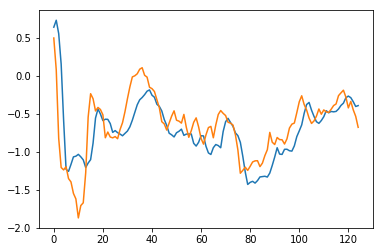

In [37]:
y_pred = []
y_act = []
running_test_loss = []

# evaluating LSTM is slightly different, only take last output in sequence
for i, data in enumerate(testloader):
    with torch.no_grad():
        y, X = data
        y, X = y.float(), X.float()
        
        loss = criterion(y, model(X))
        running_test_loss.append(loss.item())
    
        y_pred.append(model(X).squeeze()[-1][0].item())
        y_act.append(y.squeeze()[0].item())
    
plt.plot(y_pred)
plt.plot(y_act)

print("Average MSE on test set: " + str(get_average(running_test_loss)))

In [34]:
y # the loss is probably wrong

tensor([[-6.7875e-01, -3.5243e-16, -1.0747e+00]])

In [44]:
model(X)[-1]

tensor([[-0.3931, -0.2336, -1.3039]], grad_fn=<SelectBackward>)

In [41]:
criterion(y, model(X)).item()

0.04224719852209091

In [42]:
criterion(y, model(X)[-1]).item()

0.06290000677108765

In [ ]:
# god this actually seems really awful
# edit: need to train for a lot more!